The purpose is to implement Actor-Critic 
</br> two models are trained 
</br> 1. actor 
</br> 2. critic
</br> different from the official tutorial. There two model are totally indepedent and do not share any weights.
</br> the actor is used to generate actions. During training, we draw actions randomly from action space W.R.T the probability, during inference, we use ARGMAX to generate actions.

In [1]:
import numpy as np
import tensorflow as tf
import gym
import statistics
import tqdm
import collections

2023-03-10 16:41:57.825724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 16:41:57.905449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 16:41:57.905470: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-10 16:41:58.280431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
env = gym.make("CartPole-v1")
initial_state, _ = env.reset()
initial_state_shape = initial_state.shape
eps = np.finfo(np.float32).eps.item()
action_space = env.action_space.n
gamma = 1.01
lr = 0.01

# Define Model

In [3]:
def get_model_actor():
    """
    Policy function:
    P(At | St)
    """
    inputs = tf.keras.layers.Input(shape=initial_state_shape)
    dense = tf.keras.layers.Dense(32, activation="relu", name="p1")(inputs)
    out = tf.keras.layers.Dense(2, activation=None, name="p_out")(dense)
    return tf.keras.Model(inputs, out)

def get_model_critic():
    """
    action-value function:
    Q(At, St)
    """
    inputs = tf.keras.layers.Input(shape=initial_state_shape)
    dense = tf.keras.layers.Dense(32, activation="relu", name="q1")(inputs)
    out = tf.keras.layers.Dense(2, activation=None, name="q_out")(dense)
    return tf.keras.Model(inputs, out)

model_actor = get_model_actor()
model_critic = get_model_critic()

2023-03-10 16:41:58.800660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 16:41:58.800804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 16:41:58.800833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-10 16:41:58.800855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-10 16:41:58.800875: W tensorflow/c

In [4]:
model_actor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 p1 (Dense)                  (None, 32)                160       
                                                                 
 p_out (Dense)               (None, 2)                 66        
                                                                 
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [5]:
model_critic.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 q1 (Dense)                  (None, 32)                160       
                                                                 
 q_out (Dense)               (None, 2)                 66        
                                                                 
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


# Collect Train Data

In [6]:
def env_next(action):
    state, reward, done, _, _ = env.step(action)
    return (
        state.astype(np.float32), 
        np.array(reward, np.float32), 
        np.array(done, np.int32)
    )

def tf_env_next(action):
    return tf.numpy_function(env_next, [action], [tf.float32, tf.float32, tf.int32])

# This is the TD traning frame work. Different from the official tutorial, the model does not need to wait until the end of the game
# to update the weight
def run_next_step(start_state, cur_step, step_length, model_actor, model_critic):
    actions = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    action_probs = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    state = start_state
    for t in tf.range(step_length):
        cur_step += 1
        state = tf.expand_dims(state, 0)
        action_logits = model_actor(state)
        qvalue = model_critic(state)
        # the tf.random.categorical take unnormalize logits.
        action = tf.random.categorical(action_logits, 1, dtype=tf.int32)[0,0]
        action_prob = tf.keras.activations.softmax(action_logits)
        
        state, reward, done = tf_env_next(action)
        state.set_shape(initial_state_shape)
        
        actions = actions.write(t, tf.squeeze(action))
        action_probs = action_probs.write(t, tf.squeeze(action_prob))
        values = values.write(t, tf.squeeze(qvalue))
        rewards = rewards.write(t, tf.squeeze(reward))
        
        done = tf.cast(done, tf.bool)
        
        if done:
            break
    actions = actions.stack()
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    
    # Below is the TD learning purpose
    #Q_T - Qt = UT - Ut. Where UT - Ut is known.
    action_logits_next = model_actor(tf.expand_dims(state, 0))
    value_next = model_critic(tf.expand_dims(state, 0))
    action_next_prob = tf.keras.activations.softmax(action_logits_next)
    action_next_prob = tf.squeeze(action_next_prob)
    value_next = tf.squeeze(value_next)
    
    return actions, action_probs, values, rewards, state, done, cur_step, action_next_prob, value_next
    
        

## test output

In [7]:
initial_state, _ = env.reset()
A = run_next_step(initial_state, 0, 500, model_actor, model_critic)

/home/wei/anaconda3/envs/tf_211/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [8]:
A

(<tf.Tensor: shape=(49,), dtype=int32, numpy=
 array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1], dtype=int32)>,
 <tf.Tensor: shape=(49, 2), dtype=float32, numpy=
 array([[0.5010201 , 0.49898   ],
        [0.52598375, 0.47401628],
        [0.55402935, 0.4459707 ],
        [0.58105755, 0.41894242],
        [0.55195993, 0.44803998],
        [0.5794428 , 0.4205572 ],
        [0.5507191 , 0.44928086],
        [0.522255  , 0.47774506],
        [0.51143324, 0.48856676],
        [0.5225053 , 0.47749472],
        [0.5511438 , 0.44885617],
        [0.523346  , 0.476654  ],
        [0.51407236, 0.48592758],
        [0.5239655 , 0.47603446],
        [0.55272865, 0.44727138],
        [0.58122885, 0.41877115],
        [0.55358166, 0.44641832],
        [0.52717316, 0.47282687],
        [0.5118678 , 0.4881321 ],
        [0.5365937 , 0.4634063 ],
        [0.5609156 , 0.43908447],
   

# calculate return

In [9]:
def calculate_returns(rewards):
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    returns = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for t in tf.range(tf.shape(rewards)[0]-1, -1, -1):
        discounted_sum = gamma * discounted_sum + rewards[t]
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(t, discounted_sum)
    returns = returns.stack()
    # below standardize is optional
#     returns = (returns - tf.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps)
    return returns

## test output

In [10]:
calculate_returns(A[3])

<tf.Tensor: shape=(49,), dtype=float32, numpy=
array([62.834824 , 61.2226   , 59.626335 , 58.045876 , 56.481064 ,
       54.931747 , 53.39777  , 51.87898  , 50.375225 , 48.88636  ,
       47.41224  , 45.952713 , 44.507637 , 43.07687  , 41.660267 ,
       40.25769  , 38.869    , 37.49406  , 36.132732 , 34.784885 ,
       33.450382 , 32.129093 , 30.820885 , 29.525629 , 28.243196 ,
       26.973463 , 25.716301 , 24.471586 , 23.239195 , 22.019005 ,
       20.810896 , 19.614748 , 18.430443 , 17.257864 , 16.096895 ,
       14.947421 , 13.809328 , 12.682503 , 11.566834 , 10.462213 ,
        9.368527 ,  8.285671 ,  7.2135353,  6.152015 ,  5.101005 ,
        4.060401 ,  3.0300999,  2.01     ,  1.       ], dtype=float32)>

In [11]:
actions, action_probs, values, rewards, state, done, cur_step, action_next_prob, value_next = A

# Loss

In [12]:
"""
J(S;theta) = E_A[ Policy(A|S)*Q_value(A|S) ] -> expectation over A
J is also call state value function.

Here we will compute the loss the Q_value to make sure the critic can decide the value more accurately.
Treat the Q as Q*

Q(At, St; w) = r + gamma*r + gamma**2*r + ...+ gamma**T*r+ Q(At_T+1, St_T+1;w)

State_value_T - State_value_t = UT - Ut
UT - Ut can be collected while playing the game.

State_value_t = E[Q_value_t(At, St)] = Policy(A1|S) * Q(A1,St) + Policy(A2|S) * Q(A2,St) + ...
advantage = (UT - Ut) - (ST - St); where (ST - St) is optional.

loss_critic = LOSS(UT - Ut, State_value_T - State_value_t)
loss_actor = - log(action_prob) * advantage. Where advantage. The purpose to incluse this term is to let the actor push action_prob to 1.0

"""

loss_func = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)


def compute_critic_loss_v2(action_probs, actions, values, returns, action_next_prob, value_next):
    state_value = tf.reduce_sum(action_probs * values, axis=1)
    state_value_t = tf.reduce_sum(action_next_prob * value_next)
    state_value_TD =  state_value - state_value_t
#     advantage: either of below is OK.
    advantage = returns - state_value_TD
#     advantage = returns
    
    # since the action is 1-D like 1 0 1 0 1 1 ... Below can convert it to (batch, action_space)
    actions_one_hot = tf.one_hot(actions, depth=2)
    # 1-D tensor to extract the corresponding action prob
    action_prob_1d = tf.math.reduce_sum(actions_one_hot * action_probs, axis=1)
    log_actions = tf.math.log(tf.clip_by_value(action_prob_1d, eps, 1.0))
    loss_actor = - tf.reduce_sum(log_actions * advantage)
    loss_critic = loss_func(tf.expand_dims(state_value_TD,1), tf.expand_dims(returns, 1))
    loss = loss_actor + loss_critic
    return loss, loss_actor, loss_critic
    


## test ouput

In [13]:
compute_critic_loss_v2(A[1], A[0], A[2], calculate_returns(A[3]), A[-2], A[-1])

(<tf.Tensor: shape=(), dtype=float32, numpy=59722.707>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1015.5073>,
 <tf.Tensor: shape=(), dtype=float32, numpy=58707.2>)

# Train Step

In [14]:
optimizer_actor = tf.keras.optimizers.Adam(learning_rate=lr)
optimizer_critic = tf.keras.optimizers.Adam(learning_rate=lr)



@tf.function
def train_step_v2(start_state, cur_step, step_length, model_actor, model_critic, optimizer_actor, optimizer_critic):
    with tf.GradientTape(persistent=True) as tape:
        STEP = run_next_step(start_state, cur_step, step_length, model_actor, model_critic)
        actions, action_probs, values, rewards, state, done, cur_step, action_next_prob, value_next = STEP
        returns = calculate_returns(rewards)
        loss, loss_actor, loss_critic = compute_critic_loss_v2(action_probs, actions, values, returns, action_next_prob, value_next)
    gradient_critic = tape.gradient(loss_critic, model_critic.trainable_variables)
    gradient_actor = tape.gradient(loss_actor, model_actor.trainable_variables)
    optimizer_actor.apply_gradients(zip(gradient_actor, model_actor.trainable_variables))
    optimizer_critic.apply_gradients(zip(gradient_critic, model_critic.trainable_variables))
    return STEP, loss

## test output

In [15]:
initial_state, _ = env.reset()
R = train_step_v2(initial_state, 0, 500, model_actor, model_critic, optimizer_actor, optimizer_critic)

In [16]:
R

((<tf.Tensor: shape=(21,), dtype=int32, numpy=
  array([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        dtype=int32)>,
  <tf.Tensor: shape=(21, 2), dtype=float32, numpy=
  array([[0.50523806, 0.49476197],
         [0.52933437, 0.47066572],
         [0.5033358 , 0.49666426],
         [0.5282245 , 0.4717755 ],
         [0.5561089 , 0.4438911 ],
         [0.5836225 , 0.4163775 ],
         [0.5550315 , 0.44496858],
         [0.52650136, 0.47349864],
         [0.5037555 , 0.49624446],
         [0.53237486, 0.4676251 ],
         [0.50104296, 0.49895698],
         [0.52822286, 0.4717771 ],
         [0.5568779 , 0.44312218],
         [0.58511454, 0.41488552],
         [0.61284775, 0.38715222],
         [0.6399926 , 0.3600074 ],
         [0.61387354, 0.3861264 ],
         [0.5877723 , 0.41222772],
         [0.56116545, 0.43883446],
         [0.5915759 , 0.4084241 ],
         [0.6212302 , 0.37876984]], dtype=float32)>,
  <tf.Tensor: shape=(21, 2), dtype=float32, numpy=
  

# Run

In [17]:
min_epoches = 100
max_epoches = 10000
rewards_threads = 475
step_length = 50
max_steps_per_epoches = 2000
t = tqdm.trange(max_epoches)

running_rewards = collections.deque(maxlen=min_epoches)
running_loss = collections.deque(maxlen=min_epoches)
all_rewards_list = []
all_loss_list = []
all_flat_loss_list = []


for i in t:
    initial_sate, _ = env.reset()
    initial_sate = tf.constant(initial_sate, tf.float32)
    state = initial_sate
    cur_step = tf.constant(0, tf.int32)
    epoch_rewards = 0
    step_loss = 0
    n_steps = 0
    while True:
        STEP, loss = train_step_v2(state, cur_step, step_length, model_actor, model_critic, optimizer_actor, optimizer_critic)
        actions, action_probs, values, rewards, state, done, cur_step, action_prob_next, value_next = STEP
        rewards = tf.reduce_sum(rewards)
        epoch_rewards += int(rewards)
        n_steps += 1
        step_loss += float(loss)
        if cur_step >= max_steps_per_epoches or done:
            break
    
    step_loss = step_loss / n_steps
    running_loss.append(step_loss)
    running_rewards.append(epoch_rewards)
    rloss = statistics.mean(running_loss)
    rrewards = statistics.mean(running_rewards)
    all_loss_list.append(rloss)
    all_rewards_list.append(rrewards)
    all_flat_loss_list.append(step_loss)
    t.set_postfix(current_rewards=epoch_rewards, running_rewards=rrewards, running_loss=rloss)
    if i > min_epoches and rrewards > rewards_threads:
        break
            
        
        
    
    

 11%|█         | 1123/10000 [00:53<07:06, 20.83it/s, current_rewards=2000, running_loss=2.27e+4, running_rewards=479]  


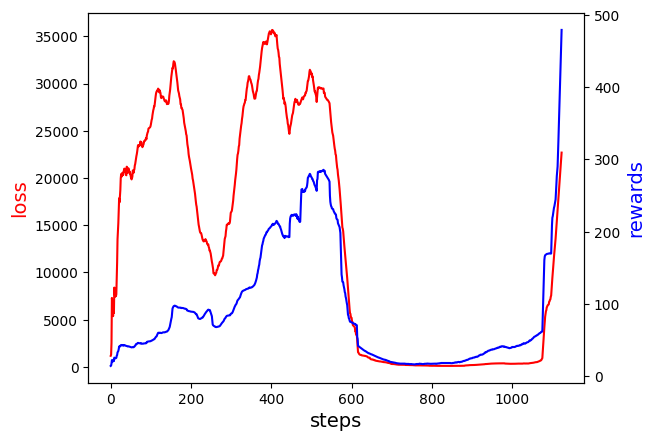

In [18]:
import matplotlib.pyplot as plt
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(range(len(all_loss_list)),
        all_loss_list,
        color="red")
# set x-axis label
ax.set_xlabel("steps", fontsize = 14)
# set y-axis label
ax.set_ylabel("loss",
              color="red",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(len(all_rewards_list)), all_rewards_list, color="blue")
ax2.set_ylabel("rewards",color="blue",fontsize=14)
plt.show()

In [19]:
state, _ = env.reset()
R,loss = train_step_v2(state, 0, 500, model_actor, model_critic, optimizer_actor, optimizer_critic)

In [20]:
actions, action_probs, values, rewards, state, done, cur_step, action_logits_next, value_next = R
returns = calculate_returns(rewards)
action_prob_next = tf.keras.activations.softmax(tf.expand_dims(action_logits_next, 0))

In [21]:
print("action: \n", actions, "\naction probs: \n", action_probs, "\nvalues: \n", values, )

action: 
 tf.Tensor(
[1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0
 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1
 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0
 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0
 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0
 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 0

# Visualization

In [22]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("CartPole-v1", render_mode='rgb_array')

def render_episode(env: gym.Env, model_actor, model_critic, max_steps: int): 
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]

  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_logits = model_actor(state)
    values = model_critic(state)
    action_probs = tf.keras.activations.softmax(action_logits)
    action_value = action_probs * values
    action = np.argmax(action_probs)

    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
images = render_episode(render_env, model_actor, model_critic, max_steps_per_epoches)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


/home/wei/anaconda3/envs/tf_211/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



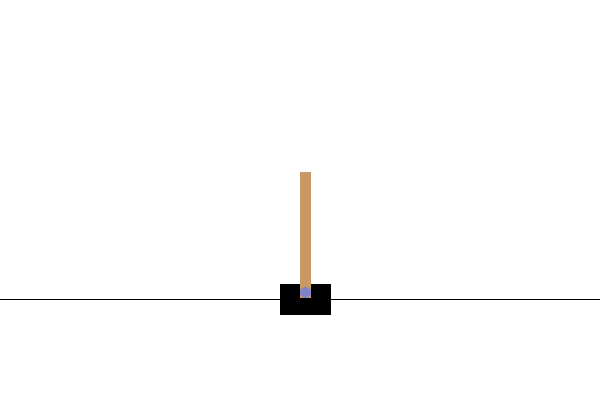

In [23]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)